In [ ]:
import pandas as pd
import numpy as np

In [104]:
def format_stars(stars):
    stars = stars.split(', \'')
    stars = [star for star in stars if star != '' and star != '    Stars:\'']
    stars[0] = stars[0][2:]
    stars[-1] = stars[-1][:-2]

    dir_index = -1
    for j in range(len(stars)):
        stars[j] = stars[j].replace(', "', '')
        if 'Stars:\'' in stars[j]:
            stars[j] = stars[j].split(':\'')[1]
        
        if '|' in stars[j]:
            dir_index = j
    
    stars = stars[dir_index + 1:]

    return stars

def format_genres(genre):
    return genre.split(', ')

def format_years(year):
    if len(year) < 5 or year[1] not in ['1', '2']:
        return -1
    return int(year[1:5])

def set_is_tv(certificate):
    tv_certs = ['TV-Y', 'TV-Y7', 'TV-Y7-FV','TV-G','TV-PG','TV-14', 'TV-MA']

    if certificate in tv_certs:
        return True
    return False

def get_cleaned_dataframe():
    df = pd.read_csv('./n_movies.csv')
    df = df.drop(columns=['description', 'votes', 'duration'])
    df = df.dropna(subset=['stars'])
    df = df.drop_duplicates(subset=['title'])
    df = df.set_index('title')
    df = df.fillna('')

    df['stars'] = df['stars'].apply(format_stars)
    df['genre'] = df['genre'].apply(format_genres)
    df['year'] = df['year'].apply(format_years)
    df['is_tv'] = df['certificate'].apply(set_is_tv)

    return df


In [106]:
df = get_cleaned_dataframe()

(7912, 6)


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 252.20it/s]


0


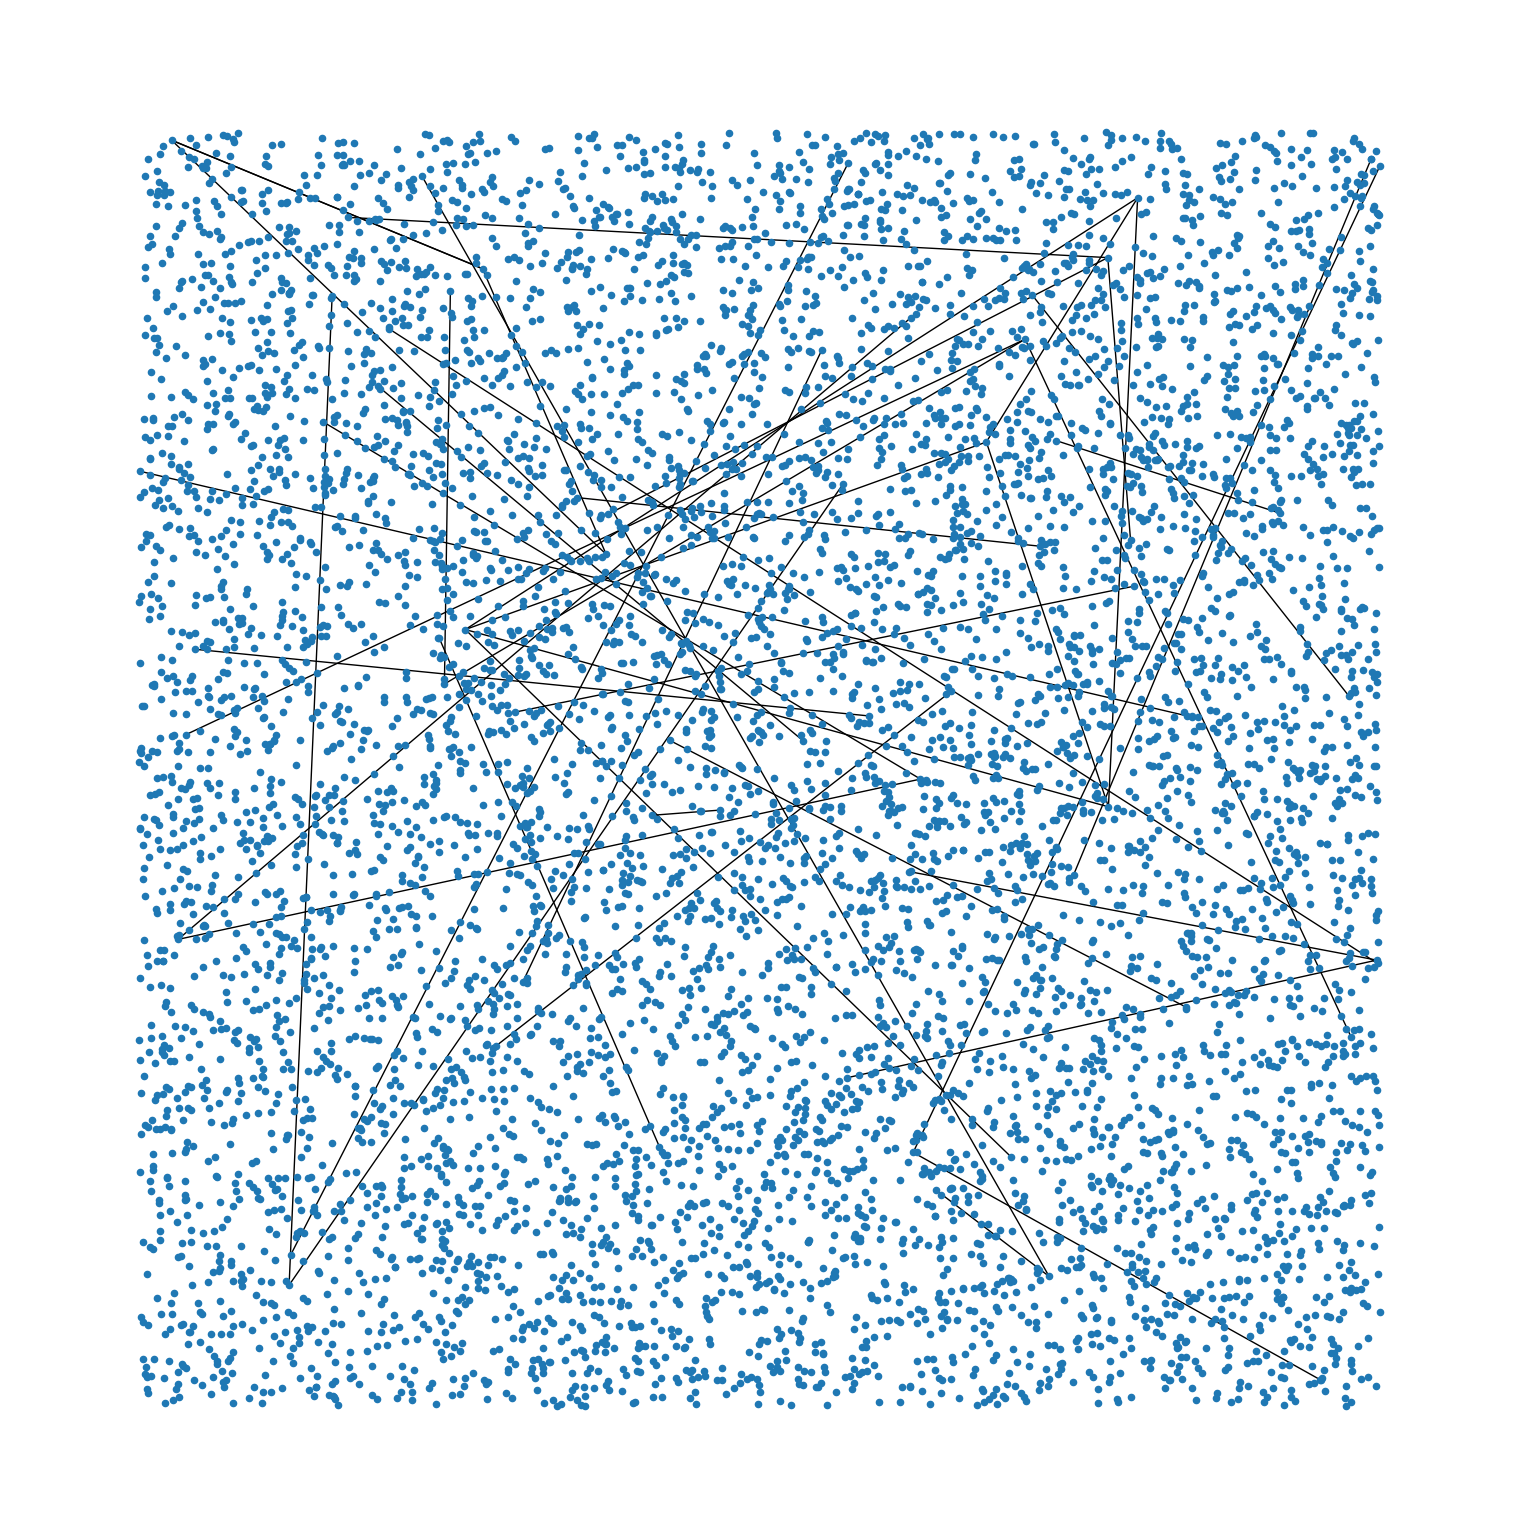

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
#from pyvis.network import Network

# Network Visualization of Movies with shared actors

movie_network = nx.MultiGraph()
movies = df['title']
for i in tqdm(range(len(movies))):
    movie_network.add_node(movies[i])

for i in tqdm(range(1250, 1500)):
    for j in range(i + 1, 1500):
        for actor in df.loc[i, 'actors']:
            if actor in df.loc[j, 'actors']:
                movie_network.add_edge(movies[i], movies[j])
                
# smaller nodes and fonts
plt.figure(1, figsize=(15,15))
nx.draw_random(movie_network, node_size=20) 
print(nx.number_of_selfloops(movie_network))
plt.show()
